In [ ]:
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from itertools import chain

from projectwind.data import get_data
from projectwind.clean import clean_timesteps

from sklearn import set_config; set_config(display='diagram')

# LSTM_data.py

In [ ]:
data = get_data(25)

In [ ]:
save = data.copy()

## Quick check on number of NaN over the period

In [ ]:
# Count number of na
isna_df = data[0].isna().sum(axis=1) / len(data[0].columns)

# Resample on daily basis
daily_data = isna_df.resample('D').sum() / 6 # divide by # periods to get ~ 24hr % missing values

# Graph output
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(x=daily_data.index, height=daily_data.values);

In [ ]:
# Good to see there are less missing values towards end of data 
# (meaning test and validation sets should be of better quality than train set)

## Data engineering

### Interpolate all NaNs

In [ ]:
from projectwind.LSTM_preproc import clean_LSTM_data

In [ ]:
full_data = clean_LSTM_data(data)

### Create wind speed & direction vectors and misalignment to average wind farm vector

In [ ]:
# Average wind speeds & directions over the wind turbines
wind_speeds = pd.DataFrame()
nacelle_dir = pd.DataFrame()
misalignment = pd.DataFrame()
for idx, WTG_data in enumerate(data):
    wind_speeds[idx] = WTG_data['Wind Speed']
    nacelle_dir[idx] = WTG_data['Nacelle Orientation']
    misalignment[idx] = WTG_data['Misalignment']

In [ ]:
for idx in misalignment:
    misalignment[idx] = misalignment[idx].apply(lambda x: x if x <=180 else (360 - x)*-1)

In [ ]:
wind_dir = pd.DataFrame()
for idx in misalignment:
    wind_dir[idx] = nacelle_dir[idx] - misalignment[idx]

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(len(nacelle_dir.columns)):
    row, col = i//5, i%5
    axes[row,col].hist2d(wind_dir[i], wind_speeds[i], bins=(50, 50), vmax=400)
    plt.xlabel('Wind Direction [deg]')
    plt.ylabel('Wind Velocity [m/s]');
plt.tight_layout()

In [ ]:
wind_X_vector = pd.DataFrame()
wind_Y_vector = pd.DataFrame()
for idx in wind_dir:
    wind_dir[idx] = wind_dir[idx] * np.pi / 180 # convert to radians
    wind_X_vector[idx] = wind_speeds[idx] * np.cos(wind_dir[idx])  # get X vector
    wind_Y_vector[idx] = wind_speeds[idx] * np.sin(wind_dir[idx])  # get Y vector
    wind_X_vector[idx] = wind_speeds[idx] * np.cos(wind_dir[idx])  # get X vector
    wind_Y_vector[idx] = wind_speeds[idx] * np.sin(wind_dir[idx])  # get Y vector

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(len(nacelle_dir.columns)):
    row, col = i//5, i%5
    axes[row,col].hist2d(wind_X_vector[i], wind_Y_vector[i], bins=(50, 50), vmax=400)
    plt.xlabel('Wind X [m/s]')
    plt.ylabel('Wind Y [m/s]');
plt.tight_layout()

In [ ]:
for idx, WTG_data in enumerate(data):
    WTG_data['WTG_wind_X'] = wind_X_vector[idx]
    WTG_data['WTG_wind_Y'] = wind_Y_vector[idx]
#     WTG_data['Misalign_wind_X'] = average['X_vector'] - wind_X_vector[idx] # Creates data leakage!
#     WTG_data['Misalign_wind_Y'] = average['Y_vector'] - wind_Y_vector[idx] # Creates data leakage!
    WTG_data.drop(columns=['Misalignment','Nacelle Orientation'], inplace=True)

### Power vs. Rotor Speed check

In [ ]:
temp = data[19].loc['2020-03-05':'2020-03-06']

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(x=temp.index, y=temp['Power']/150)
sns.lineplot(x=temp.index, y=temp['Rotor Speed'])
sns.lineplot(x=temp.index, y=temp['Wind Speed'])
fig.legend(['Power','Rotor Speed', 'Wind Speed']);

### Sine/Cosine Time

In [ ]:
df = pd.DataFrame(index=data[0].index)
timestamp_s = data[0].index.map(pd.Timestamp.timestamp)

day = 24*60*60

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

In [ ]:
plt.plot(df.iloc[0:792,0])
plt.plot(df.iloc[0:792,1]);

In [ ]:
for WTG_data in data:
    WTG_data['Day sin'] = df['Day sin']
    WTG_data['Day cos'] = df['Day cos']

## Split the data

In [ ]:
df = data[0]
df.head()

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data Windowing

In [ ]:
import tensorflow as tf

In [ ]:
df.head()

### Example

In [ ]:
data[2]

In [ ]:
df.columns

In [43]:
w1 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=df.columns)
w1

NameError: name 'WindowGenerator' is not defined

In [ ]:
w2 = WindowGenerator(input_width=24*5*6, label_width=12*6, shift=12*6,
                     label_columns=['Power'])
w2

In [ ]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

In [ ]:
for i in w2.train.take(25):
    print(i)

In [ ]:
for example_inputs, example_labels in w2.train.take(100):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
dataset = w2.train.take(1)

In [ ]:
for sequence in dataset:
    sequence.plot()

### Adaptation

In [187]:
from projectwind.LSTM_data import WindowGenerator, get_LSTM_data, define_window

In [188]:
train_df, val_df, test_df = get_LSTM_data(2)

/home/shmiggit/code/AmaurySalles/projectwind/raw_data
1
2


In [199]:
# Create window
n_steps_in =  24 * 6     # 24hrs x 6 periods of 10min
n_steps_out = 12 * 6    # 12hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_df[0], val_df[0], test_df[0])

In [200]:
def make_dataset(data):
    X_datasets = []
    y_datasets = []
    
    for WTG_data in data:
        
        # Find sequences according to window size of X and y
        WTG_data = np.array(WTG_data, dtype=np.float32)
        WTG_sequences = tf.keras.utils.timeseries_dataset_from_array(data=WTG_data,
                                                                    targets=None,
                                                                    sequence_length=window.total_window_size,
                                                                    sampling_rate=1,
                                                                    sequence_stride=window.total_window_size,
                                                                    shuffle=False,
                                                                    batch_size=32)
        # Split X and y according to window size
        WTG_sequences = WTG_sequences.map(window.split_window)
        
        # Transfer from tensor to numpy array to save under .NPY format
        X_datasets.append(chain.from_iterable([X.numpy() for X, y in WTG_sequences]))
        y_datasets.append(chain.from_iterable([y.numpy() for X, y in WTG_sequences]))
        
    # Aggregate WTGs batches into same array
    X_array = np.array(list(chain.from_iterable(X_datasets)))
    y_array = np.array(list(chain.from_iterable(y_datasets)))
    
    #X_array, y_array = shuffle_sequences(X_array, y_array)
        
    return X_array, y_array

In [201]:
# Make datasets
X_train, y_train = make_dataset(train_df)
X_val, y_val = make_dataset(val_df)
X_test, y_test = make_dataset(test_df)

In [202]:
# Verify dataset shapes
print(f"Train set shape:  X: {X_train.shape}, Y: {y_train.shape}")
print(f"Val set shape:    X: {X_val.shape},  Y: {y_val.shape}")
print(f"Test set shape:   X: {X_test.shape},  Y: {y_test.shape}")

Train set shape:  X: (820, 144, 10), Y: (820, 72, 1)
Val set shape:    X: (234, 144, 10),  Y: (234, 72, 1)
Test set shape:   X: (116, 144, 10),  Y: (116, 72, 1)


In [203]:
def shuffle_sequences(X, y, seed=42):
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)
    return X, y

In [204]:
X_train, y_train = shuffle_sequences(X_train, y_train, seed=1)
X_val, y_val = shuffle_sequences(X_val, y_val, seed=2)
X_test, y_test = shuffle_sequences(X_test, y_test, seed=3)

In [205]:
# Verify dataset shapes
print(f"Train set shape:  X: {X_train.shape}, Y: {y_train.shape}")
print(f"Val set shape:    X: {X_val.shape},  Y: {y_val.shape}")
print(f"Test set shape:   X: {X_test.shape},  Y: {y_test.shape}")

Train set shape:  X: (820, 144, 10), Y: (820, 72, 1)
Val set shape:    X: (234, 144, 10),  Y: (234, 72, 1)
Test set shape:   X: (116, 144, 10),  Y: (116, 72, 1)


In [ ]:
sequence_name = f"{window.input_width // 6}-{window.label_width//6}"
np.save(f'./projectwind/data/LSTM_sequence_X_train_{sequence_name}.npy', np.asanyarray(X_train, dtype=object))
np.save(f'./projectwind/data/LSTM_sequence_y_train_{sequence_name}.npy', np.asanyarray(y_train, dtype=object))
np.save(f'./projectwind/data/LSTM_sequence_X_val_{sequence_name}.npy', np.asanyarray(X_val, dtype=object))
np.save(f'./projectwind/data/LSTM_sequence_y_val_{sequence_name}.npy', np.asanyarray(y_val, dtype=object))
np.save(f'./projectwind/data/LSTM_sequence_X_test_{sequence_name}.npy', np.asanyarray(X_test, dtype=object))
np.save(f'./projectwind/data/LSTM_sequence_y_test_{sequence_name}.npy', np.asanyarray(y_test, dtype=object))

In [ ]:
train_ds = np.load(f'./projectwind/data/LSTM_sequence_train_datasets.npy', allow_pickle=True)

In [ ]:
len(train_ds)

In [ ]:
for inputs, labels in train_ds:
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

### Test of python file

In [ ]:
from projectwind.LSTM_data import WindowGenerator, get_LSTM_data, define_window

In [ ]:
train_df, val_df, test_df = get_LSTM_data(2)

In [ ]:
len(train_df[0])

In [82]:
n_steps_in =  24 * 6     # 24hrs x 6 periods of 10min
n_steps_out = 12 * 6    # 12hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_df[0], val_df[0], test_df[0])

In [84]:
for inputs, labels in window.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (32, 720, 9)
Labels shape (batch, time, features): (32, 72, 1)


# LSTM_model.py

## Load Dataset

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from projectwind.LSTM_data import get_LSTM_data, define_window, load_datasets

In [4]:
train_df, val_df, test_df = get_LSTM_data(2)

/home/shmiggit/code/AmaurySalles/projectwind/raw_data
1
2


In [5]:
n_steps_in = 5 * 24 * 6     # 5 day x 24hrs x 6 periods of 10min
n_steps_out = 12 * 6    # 12hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_df, val_df, test_df)

In [7]:
X_train, y_train = window.train
X_val, y_val = window.val
X_test, y_test = window.test

In [39]:
train_ds = window.train
val_ds = window.val
test_ds = window.test

In [41]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 720, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 72, 1), dtype=tf.float32, name=None))>

In [14]:
# Verify dataset shapes
print(f"Train set shape:  X: {X_train.shape},  Y: {y_train.shape}")
print(f"Val set shape:    X: {X_val.shape},  Y: {y_val.shape}")
print(f"Test set shape:   X: {X_test.shape},  Y: {y_test.shape}")

Train set shape:  X: (224, 720, 9),  Y: (224, 72, 1)
Val set shape:    X: (64, 720, 9),  Y: (64, 72, 1)
Test set shape:   X: (32, 720, 9),  Y: (32, 72, 1)


## Create LSTM_model

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance = multi_lstm_model.evaluate(window.val)
multi_performance = multi_lstm_model.evaluate(window.test, verbose=0)
multi_window.plot(multi_lstm_model)


## Create feedback_model 

In [180]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        # First layer
        self.lstm_cell = tf.keras.layers.LSTMCell(units) 
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True) #Wrap the LSTMCell in an RNN to simplify the `warmup` method.
        # Second layer
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        # Output layer
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []

        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

    def compile_and_fit(model, window, patience=2):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

        model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = model.fit(window.train, epochs=MAX_EPOCHS,
                          validation_data=window.val,
                          callbacks=[early_stopping])
        return history

In [181]:
for inputs, labels in window.train.take(1):
    num_features = inputs.shape[2]
    n_steps_in = inputs.shape[1]
    n_steps_out = labels.shape[1]

In [182]:
feedback_model = FeedBack(units=32, out_steps=n_steps_out)

In [183]:
prediction, state = feedback_model.warmup(window.example[0])
prediction.shape

TensorShape([32, 9])

In [184]:
feedback_model(window.example[0])

<tf.Tensor: shape=(32, 72, 9), dtype=float32, numpy=
array([[[ 5.2045983e-01,  5.9654051e-01,  3.9352515e-01, ...,
         -5.6970996e-01,  4.4280520e-01,  3.3732885e-01],
        [ 3.0928394e-01,  5.9326494e-01,  6.9828051e-01, ...,
         -1.8069698e-01,  3.0076838e-01,  7.9007782e-02],
        [ 3.0246091e-01,  5.5901200e-01,  6.6558838e-01, ...,
         -1.9160736e-01,  2.4703087e-01,  8.6119592e-02],
        ...,
        [ 2.0046221e-04,  2.6492903e-04, -1.0994019e-04, ...,
         -2.0893011e-04,  2.8999062e-04,  3.2080230e-04],
        [ 1.7812529e-04,  2.4464025e-04, -9.7751486e-05, ...,
         -1.8099399e-04,  2.5445202e-04,  2.9795273e-04],
        [ 1.5813357e-04,  2.2550831e-04, -8.6679531e-05, ...,
         -1.5645566e-04,  2.2321384e-04,  2.7622905e-04]],

       [[ 6.3920099e-01, -1.0590988e-01,  8.3847994e-01, ...,
         -1.8063404e-01,  2.3732738e-01, -4.3725684e-01],
        [ 3.0132526e-01,  1.1093785e-01,  5.3146011e-01, ...,
         -1.9352199e-01,  8.33

In [185]:
print('Output shape (batch, time, features): ', feedback_model(window.example[0]).shape)

Output shape (batch, time, features):  (32, 72, 9)


In [123]:
MAX_EPOCHS = 20
history = compile_and_fit(feedback_model, window)

Epoch 1/20
4/4 [==============================] - 14s 1s/step - loss: 1024214.6875 - mean_absolute_error: 764.4233 - val_loss: 1707489.5000 - val_mean_absolute_error: 1085.7296
Epoch 2/20
4/4 [==============================] - 3s 864ms/step - loss: 1024041.4375 - mean_absolute_error: 764.3367 - val_loss: 1707155.2500 - val_mean_absolute_error: 1085.5994
Epoch 3/20
4/4 [==============================] - 4s 891ms/step - loss: 1023774.0000 - mean_absolute_error: 764.1987 - val_loss: 1706661.3750 - val_mean_absolute_error: 1085.4082
Epoch 4/20
4/4 [==============================] - 3s 728ms/step - loss: 1023418.5625 - mean_absolute_error: 764.0135 - val_loss: 1706179.0000 - val_mean_absolute_error: 1085.2218
Epoch 5/20
4/4 [==============================] - 3s 706ms/step - loss: 1023098.8125 - mean_absolute_error: 763.8422 - val_loss: 1705740.1250 - val_mean_absolute_error: 1085.0519
Epoch 6/20
4/4 [==============================] - 3s 687ms/step - loss: 1022786.3125 - mean_absolute_error:

In [186]:
feedback_model.predict(X_test).shape

(32, 72, 9)

1/1 [==============================] - 0s 102ms/step - loss: 1699176.5000 - mean_absolute_error: 1082.5161


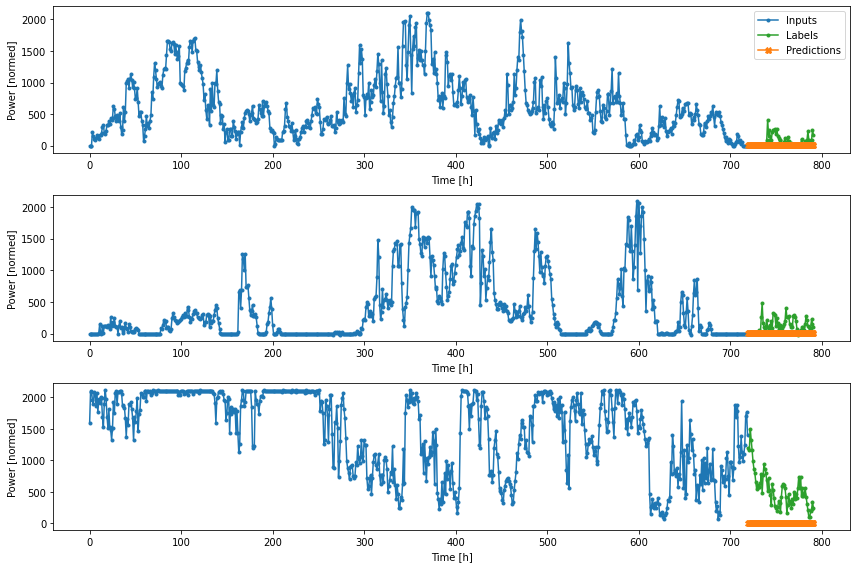

In [135]:
val_performance = feedback_model.evaluate(window.val)
test_performance = feedback_model.evaluate(window.test, verbose=0)
window.plot(feedback_model)

# OLD - LSTM_data_preproc

In [ ]:
raw_data = get_data(25)

In [ ]:
raw_data[13]

In [ ]:
data = clean_timesteps(raw_data)
data = clean_LSTM_data(data)

## clean_LSTM_data

In [ ]:
temp_data = data[0]

In [ ]:
index_with_nan = temp_data[temp_data.isna().any(axis=1) == True].index

In [ ]:
temp_data.loc[index_with_nan]

In [ ]:
temp_data.loc['2019-05-06 09:30':'2019-05-06 15:00']

In [ ]:
temp_data.loc['2019-05-06 09:30':'2019-05-06 15:00']

In [ ]:
for WTG_data in data:
    print(WTG_data.isna().sum().sum())
    WTG_data.interpolate(axis=0, inplace=True)
    print(WTG_data.isna().sum().sum())

##  split_LSTM_data

In [ ]:
temp = data[0]

In [ ]:
len(data[0])

In [ ]:
seq_len = int(24 * 6 * 5.5)
seq_len

In [ ]:
# Find number of seq possible
seq_num = len(data[0]) // (720+72) # per turbine
seq_num

In [ ]:
test_seq_len = int(0.2 * seq_num) # last 20% indices will belong to test set
val_seq_len  = int(0.2 * seq_num) # 2nd last 20% indices will belong to val set
test_seq_len, val_seq_len

In [ ]:
test_seq_start = seq_num - test_seq_len
val_seq_start = seq_num - test_seq_len - val_seq_len
0, val_seq_start, test_seq_start, 160

In [ ]:
test_idx_start = test_seq_start * seq_len
val_idx_start = val_seq_start * seq_len
val_idx_start, test_idx_start

In [ ]:
# Aggregated
test_idx_start = int((seq_num - (seq_num * 0.2)) * seq_len)
val_idx_start = int((seq_num - (seq_num * 0.4)) * seq_len)
val_idx_start, test_idx_start

In [ ]:
# Aggregated
seq_len = int(24 * 6 * 5.5)
seq_num = len(data[0]) // (720+72) # per turbine
test_idx_start = int(seq_num * (0.8 * seq_len))
val_idx_start = int(seq_num * (0.6 * seq_len))
val_idx_start, test_idx_start

In [ ]:
temp.iloc[val_idx_start:test_idx_start]

In [ ]:
# Test function
from projectwind.LSTM_preproc import split_train_val_test_split

In [ ]:
train, val, test = split_train_val_test_split(data, 5.5)

In [ ]:
train[0]

## get_sequence

In [ ]:
from projectwind.LSTM_preproc import get_sequences

In [ ]:
sequences = get_sequences(train, 5.5)

In [ ]:
sequences

## extract_target_from_sequences

In [ ]:
datasets = {'train':[1,2,3], 'val':[4,5], 'test':[6,7]}

In [ ]:
datasets = dict(train=[1,2,3], val=[4,5], test=[6,7])

In [ ]:
datasets

In [ ]:
for name, data in datasets.items():
    print(name)

In [ ]:
from projectwind.LSTM_preproc import extract_target_from_sequences

In [ ]:
sequences[0].shape[0]

In [ ]:
X, Y = extract_target_from_sequences(sequences, 0.5)

## init_LSTM_data

In [ ]:
from projectwind.LSTM_preproc import init_LSTM_data

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = init_LSTM_data(1, 5.5)

In [ ]:
len(X_train), len(X_val), len(X_test)

# OLD - Trainer_LSTM_model

In [ ]:
train_ds = np.load(f'./projectwind/data/LSTM_sequence_train_datasets.npy', allow_pickle=True)
val_ds = np.load(f'./projectwind/data/LSTM_sequence_val_datasets.npy', allow_pickle=True)
test_ds = np.load(f'./projectwind/data/LSTM_sequence_test_datasets.npy', allow_pickle=True)

In [195]:
from projectwind.LSTM_model import init_LSTM_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization

In [206]:
def init_LSTM_model(n_steps_in, n_steps_out, n_features):

    model = Sequential()
    model.add(BatchNormalization(input_shape=(n_steps_in, n_features)))
    model.add(LSTM(16, activation='tanh', return_sequences=True))
    model.add(LSTM(32, activation='tanh', return_sequences=False))
    model.add(Dense(n_steps_out, activation='linear'))
    model.compile(optimizer='adam', loss='huber', metrics=["mae"])

    return model

In [207]:
model = init_LSTM_model(n_steps_in=window.input_width, 
                        n_steps_out=window.label_width, 
                        n_features=len(window.column_indices))

In [208]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 144, 10)          40        
 hNormalization)                                                 
                                                                 
 lstm_6 (LSTM)               (None, 144, 16)           1728      
                                                                 
 lstm_7 (LSTM)               (None, 32)                6272      
                                                                 
 dense_15 (Dense)            (None, 72)                2376      
                                                                 
Total params: 10,416
Trainable params: 10,396
Non-trainable params: 20
_________________________________________________________________


In [ ]:
# Huber
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(X_train,y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    callbacks=[es])

Epoch 1/10
26/26 [==============================] - 7s 122ms/step - loss: 769.9515 - mae: 770.4512 - val_loss: 996.5397 - val_mae: 997.0394
Epoch 2/10
26/26 [==============================] - 4s 150ms/step - loss: 769.4641 - mae: 769.9638 - val_loss: 995.5695 - val_mae: 996.0692
Epoch 3/10
26/26 [==============================] - 9s 342ms/step - loss: 768.3507 - mae: 768.8502 - val_loss: 994.2472 - val_mae: 994.7470
Epoch 4/10
26/26 [==============================] - 9s 348ms/step - loss: 767.1949 - mae: 767.6948 - val_loss: 993.1131 - val_mae: 993.6130
Epoch 5/10
26/26 [==============================] - 7s 286ms/step - loss: 766.2221 - mae: 766.7216 - val_loss: 992.1473 - val_mae: 992.6472
Epoch 6/10
26/26 [==============================] - 7s 283ms/step - loss: 765.3652 - mae: 765.8646 - val_loss: 991.2542 - val_mae: 991.7540
Epoch 7/10
26/26 [==============================] - 10s 371ms/step - loss: 764.5710 - mae: 765.0704 - val_loss: 990.4023 - val_mae: 990.9021
Epoch 8/10
26/26 [=

In [93]:
# MAE
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(window.train,
                    validation_data=window.val,
                    epochs=2,
                    callbacks=[es])

Epoch 1/2
4/4 [==============================] - 5s 656ms/step - loss: 763.9683 - mae: 764.4677 - val_loss: 1085.3167 - val_mae: 1085.8164
Epoch 2/2
4/4 [==============================] - 3s 801ms/step - loss: 763.9554 - mae: 764.4549 - val_loss: 1085.2953 - val_mae: 1085.7950


In [ ]:
# MSE
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(window.train,
                    validation_data=(X_val, y_val),
                    epochs=2,
                    callbacks=[es])

In [ ]:
from projectwind.trainer import plot_loss

In [ ]:
plot_loss(history)

## 